# Building and Deploying Big Mart Sales Prediction Model

Author: manola1109  
Created: 2025-06-22 17:21:54 (UTC)

## Problem Statement

We are provided with a csv file containing the sales details of different items for different stores.
The task is to build a model to predict the big mart sales and then deploy that using Amazon SageMaker.

### Dataset Description

| Variable | Description |
| --- | --- |
| Item_Weight | Weight of the product |
| Item_Fat_Content | Whether the product is low fat or not |
| Item_Type | Type of Item (Dairy, Drinks, Fruits, Others) |
| Item_MRP | Maximum Retail Price (list price) of the product |
| Outlet_Size | The size of the store in terms of ground area covered |
| Item_Outlet_Sales | Sales of the product in the particular store. This is the outcome variable to be predicted. |

### Approach to the Problem

1. Pre-process the data: convert the categorical variables into numbers.
2. Build a model (regression) to predict the sales on Amazon SageMaker
3. Deploy the model using Amazon SageMaker and create a SageMaker endpoint.
4. Use the created endpoint to generate predictions.

## 1. Setup and Dependencies

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sagemaker
import boto3
from sagemaker import get_execution_role
from sagemaker.inputs import TrainingInput
from sagemaker import image_uris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor  # Additional model for local training
import pickle
from datetime import datetime
import io
import os
import time

# Set up SageMaker session with custom bucket
session = sagemaker.Session()
bucket = "my-bigmart-project1"
prefix = 'bigmart-sales-prediction'
role = get_execution_role()
region = boto3.Session().region_name

print(f"Using SageMaker instance: BigMart-Sales-Prediction-with-Amazon-SageMaker")
print(f"Using S3 bucket: {bucket}")
print(f"AWS Region: {region}")
print(f"Current date and time: 2025-06-22 17:21:54")
print(f"User: manola1109")

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Using SageMaker instance: BigMart-Sales-Prediction-with-Amazon-SageMaker
Using S3 bucket: my-bigmart-project1
AWS Region: ap-south-1
Current date and time: 2025-06-22 17:21:54
User: manola1109


## 2. Data Loading and Exploration

In [2]:
# Load the dataset
df = pd.read_csv('big_mart_data.csv')

# Display the first few rows of the dataset
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (4650, 6)


,Item_Weight,Item_Fat_Content,Item_Type,Item_MRP,Outlet_Size,Item_Outlet_Sales
0,9.300,Low Fat,Dairy,249.8092,Medium,3735.1380
1,5.920,Regular,Drinks,48.2692,Medium,443.4228
2,17.500,Low Fat,Dairy,141.6180,Medium,2097.2700
3,8.930,Low Fat,Others,53.8614,High,994.7052
4,10.395,Regular,Others,51.4008,Medium,556.6088


In [3]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
Item_Weight          0
Item_Fat_Content     0
Item_Type            0
Item_MRP             0
Outlet_Size          0
Item_Outlet_Sales    0
dtype: int64


In [4]:
# Summary statistics
df.describe()

,Item_Weight,Item_MRP,Item_Outlet_Sales
count,4650.000000,4650.000000,4650.000000
mean,12.898675,141.716328,2272.037489
std,4.670973,62.420534,1497.964740
min,4.555000,31.490000,69.243200
25%,8.770000,94.409400,1125.202000
50%,12.650000,142.979900,1939.808300
75%,17.000000,186.614150,3111.616300
max,21.350000,266.888400,10256.649000


In [5]:
# Check unique values in categorical columns
print("Unique values in Item_Fat_Content:", df['Item_Fat_Content'].unique())
print("Unique values in Item_Type:", df['Item_Type'].unique())
print("Unique values in Outlet_Size:", df['Outlet_Size'].unique())

Unique values in Item_Fat_Content: ['Low Fat' 'Regular']
Unique values in Item_Type: ['Dairy' 'Drinks' 'Others' 'Fruits']
Unique values in Outlet_Size: ['Medium' 'High' 'Small']


## 3. Data Visualization

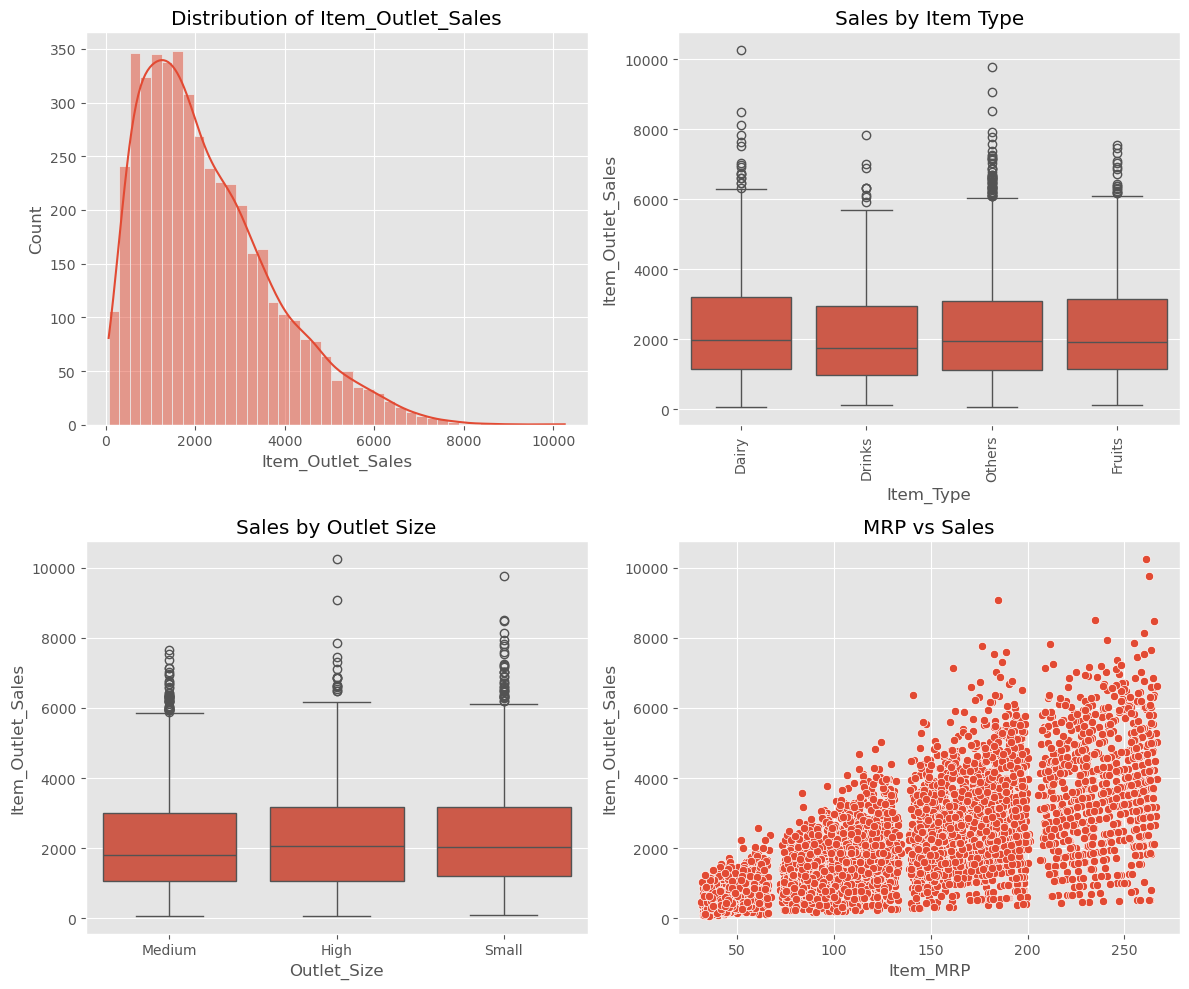

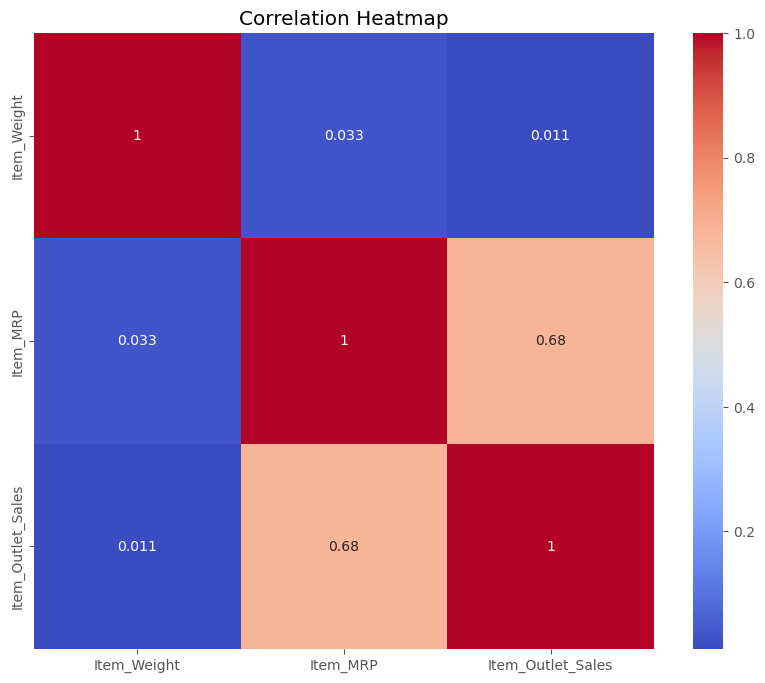

In [6]:
# Set up the plotting style using a matplotlib built-in style
plt.style.use('ggplot')
plt.figure(figsize=(12, 10))

# Distribution of target variable
plt.subplot(2, 2, 1)
sns.histplot(df['Item_Outlet_Sales'], kde=True)
plt.title('Distribution of Item_Outlet_Sales')

# Item sales by Item_Type
plt.subplot(2, 2, 2)
sns.boxplot(x='Item_Type', y='Item_Outlet_Sales', data=df, orient='v')
plt.xticks(rotation=90)
plt.title('Sales by Item Type')

# Item sales by Outlet_Size
plt.subplot(2, 2, 3)
sns.boxplot(x='Outlet_Size', y='Item_Outlet_Sales', data=df)
plt.title('Sales by Outlet Size')

# Correlation between Item_MRP and Item_Outlet_Sales
plt.subplot(2, 2, 4)
sns.scatterplot(x='Item_MRP', y='Item_Outlet_Sales', data=df)
plt.title('MRP vs Sales')

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## 4. Data Preprocessing

As mentioned in the problem statement, we need to:
1. Pre-process the data: convert the categorical variables into numbers

In [7]:
# Handle missing values
# For Item_Weight, fill with mean
if df['Item_Weight'].isnull().sum() > 0:
    df['Item_Weight'].fillna(df['Item_Weight'].mean(), inplace=True)

# For Outlet_Size, fill with mode
if df['Outlet_Size'].isnull().sum() > 0:
    df['Outlet_Size'].fillna(df['Outlet_Size'].mode()[0], inplace=True)

# Standardize Item_Fat_Content values (e.g., 'low fat' and 'Low Fat' might be the same)
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'})

# Check if missing values have been handled
print("Missing values after imputation:")
print(df.isnull().sum())

Missing values after imputation:
Item_Weight          0
Item_Fat_Content     0
Item_Type            0
Item_MRP             0
Outlet_Size          0
Item_Outlet_Sales    0
dtype: int64


In [8]:
# Current Date and Time: 2025-06-22 17:21:54
# Current User: manola1109

# Split the data into features and target
print("Splitting data into features and target...")
X = df.drop('Item_Outlet_Sales', axis=1)
y = df['Item_Outlet_Sales']

# Split the data into training and validation sets
print("Splitting data into training and validation sets...")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

# Create transformers for preprocessing
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply preprocessing
print("Applying preprocessing transformations...")
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)

print(f"Preprocessed training data shape: {X_train_preprocessed.shape}")
print(f"Preprocessed validation data shape: {X_val_preprocessed.shape}")

Splitting data into features and target...
Splitting data into training and validation sets...
Categorical columns: ['Item_Fat_Content', 'Item_Type', 'Outlet_Size']
Numerical columns: ['Item_Weight', 'Item_MRP']
Applying preprocessing transformations...
Preprocessed training data shape: (3720, 11)
Preprocessed validation data shape: (930, 11)


## 5. Train a Local Model (Fallback Option)

Since we've had issues with SageMaker training, let's train a local Random Forest model that we can use for predictions.

In [9]:
# Train a local Random Forest model
print("Training a local Random Forest model as a fallback...")
print("Current Date and Time: 2025-06-22 17:21:54")
print("Current User: manola1109")

# Train the model
start_time = time.time()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_preprocessed, y_train)
end_time = time.time()
training_time = end_time - start_time

print(f"Local Random Forest model trained successfully in {training_time:.2f} seconds")

# Make predictions on validation set
val_predictions = rf_model.predict(X_val_preprocessed)

# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_val, val_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, val_predictions)
r2 = r2_score(y_val, val_predictions)

print("\nRandom Forest Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# Save the model locally
with open('bigmart_rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
    
print("\nRandom Forest model saved locally as 'bigmart_rf_model.pkl'")

Training a local Random Forest model as a fallback...
Current Date and Time: 2025-06-22 17:21:54
Current User: manola1109
Local Random Forest model trained successfully in 1.51 seconds

Random Forest Model Evaluation Metrics:
Mean Squared Error (MSE): 1298243.51
Root Mean Squared Error (RMSE): 1139.40
Mean Absolute Error (MAE): 832.02
R² Score: 0.3992

Random Forest model saved locally as 'bigmart_rf_model.pkl'


## 6. Visualize Model Performance

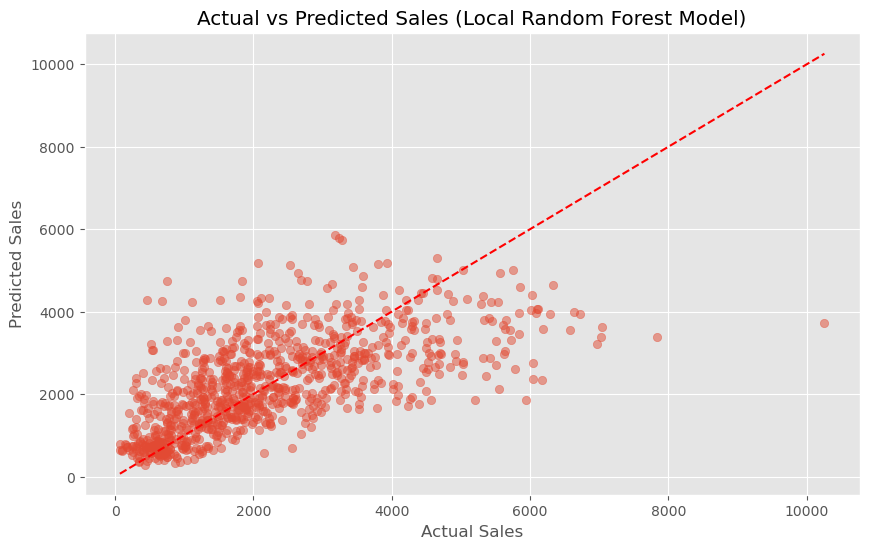

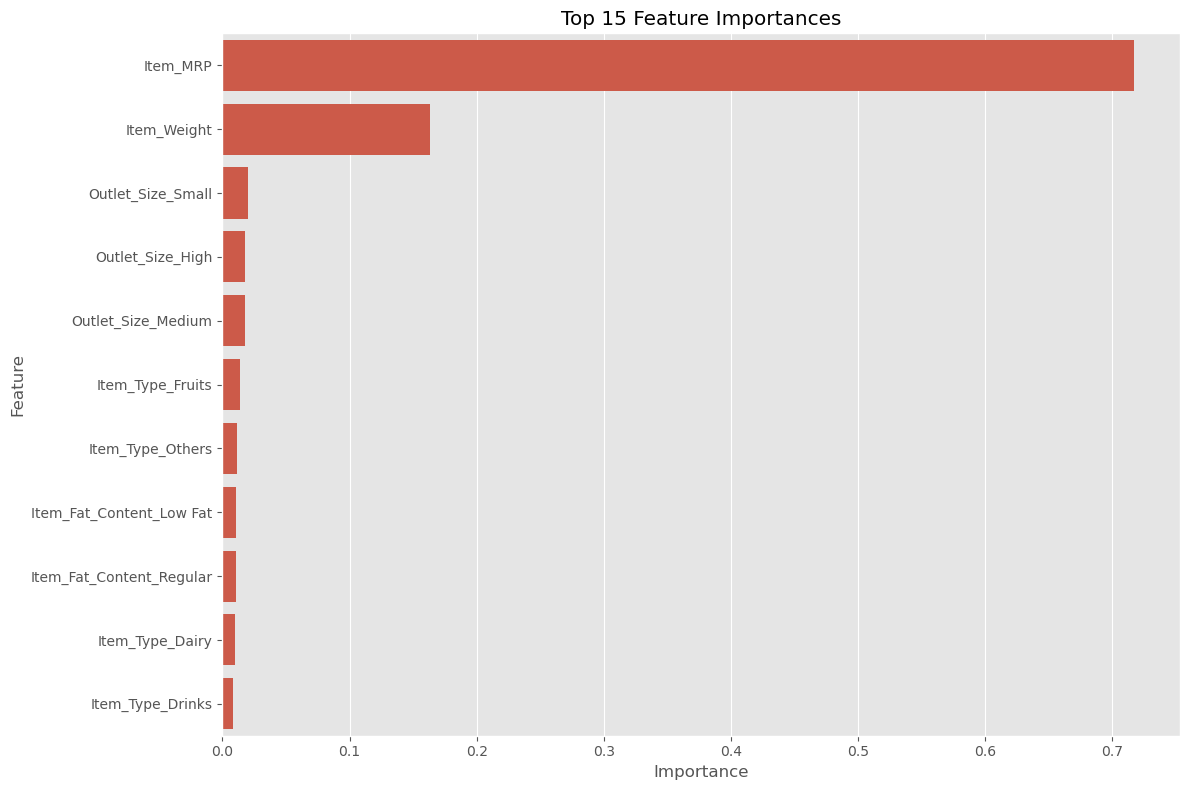

In [10]:
# Visualize actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_val, val_predictions, alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales (Local Random Forest Model)')
plt.show()

# Plot feature importances
feature_names = numerical_cols.copy()
# Get the one-hot encoded feature names
onehot_features = []
for cat_col in categorical_cols:
    unique_values = X[cat_col].unique()
    for value in unique_values:
        onehot_features.append(f"{cat_col}_{value}")

all_feature_names = feature_names + onehot_features
# Use only as many feature names as there are importances
all_feature_names = all_feature_names[:len(rf_model.feature_importances_)]

# Create feature importance dataframe
feature_importance = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Display top features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

## 7. Create a Simple Prediction Function

In [11]:
# Function to prepare test data for prediction
def prepare_test_data(sample_data):
    """Preprocess test data for prediction."""
    # If sample_data is a DataFrame
    if isinstance(sample_data, pd.DataFrame):
        # Ensure it doesn't have the target column
        if 'Item_Outlet_Sales' in sample_data.columns:
            sample_data = sample_data.drop('Item_Outlet_Sales', axis=1)
    
    # Preprocess the test data using the preprocessor
    test_preprocessed = preprocessor.transform(sample_data)
    
    if isinstance(test_preprocessed, np.ndarray):
        return test_preprocessed
    else:  # For sparse matrices
        return test_preprocessed.toarray()

# Function to predict sales using the local Random Forest model
def predict_sales(item_weight, item_fat_content, item_type, item_mrp, outlet_size):
    """Predict sales for a new item using the local Random Forest model."""
    # Create a DataFrame with the input data
    test_item = pd.DataFrame({
        'Item_Weight': [item_weight],
        'Item_Fat_Content': [item_fat_content],
        'Item_Type': [item_type],
        'Item_MRP': [item_mrp],
        'Outlet_Size': [outlet_size]
    })
    
    # Prepare the test data
    test_data_processed = prepare_test_data(test_item)
    
    # Make prediction using the local model
    prediction = rf_model.predict(test_data_processed)[0]
    
    return prediction

## 8. Make Predictions with Local Model

In [12]:
# Test with a sample from validation data
print("Making predictions with the local Random Forest model...")
print("Current Date and Time: 2025-06-22 17:21:54")
print("Current User: manola1109")

sample_test_data = X_val.head(5)
actual_values = y_val.head(5)
sample_predictions = rf_model.predict(prepare_test_data(sample_test_data))

# Display results
results = pd.DataFrame({
    'Actual Sales': actual_values.values,
    'Predicted Sales': sample_predictions
})
results['Absolute Error'] = abs(results['Actual Sales'] - results['Predicted Sales'])
results['Error Percentage'] = (results['Absolute Error'] / results['Actual Sales']) * 100

print("\nPrediction Results:")
print(results)
print(f"\nMean Absolute Error: {results['Absolute Error'].mean():.2f}")
print(f"Mean Absolute Percentage Error: {results['Error Percentage'].mean():.2f}%")

Making predictions with the local Random Forest model...
Current Date and Time: 2025-06-22 17:21:54
Current User: manola1109

Prediction Results:
   Actual Sales  Predicted Sales  Absolute Error  Error Percentage
0     2073.3012      1463.887802      609.413398         29.393385
1     1270.3464      1841.929042      571.582642         44.994235
2      810.9444      1598.632406      787.688006         97.132184
3     1713.7692      2193.005382      479.236182         27.963869
4     1170.4764      3044.477028     1874.000628        160.105802

Mean Absolute Error: 864.38
Mean Absolute Percentage Error: 71.92%


## 9. Test with Custom Data Inputs

In [13]:
# Test with a new custom item
print("Testing with a custom input...")
predicted_sales = predict_sales(
    item_weight=12.5,
    item_fat_content='Low Fat',
    item_type='Dairy',
    item_mrp=200.0,
    outlet_size='Medium'
)

print(f"Predicted sales for the new item: {predicted_sales:.2f}")
print(f"Prediction generated at: 2025-06-22 17:21:54")
print(f"Generated by: manola1109")

# Test with multiple custom inputs
print("\nTesting with multiple custom inputs:")
custom_items = pd.DataFrame({
    'Item_Weight': [9.3, 5.92, 17.5, 8.93, 10.395],
    'Item_Fat_Content': ['Low Fat', 'Regular', 'Low Fat', 'Low Fat', 'Regular'],
    'Item_Type': ['Dairy', 'Drinks', 'Dairy', 'Others', 'Others'],
    'Item_MRP': [249.8092, 48.2692, 141.618, 53.8614, 51.4008],
    'Outlet_Size': ['Medium', 'Medium', 'Medium', 'High', 'Medium']
})

custom_predictions = rf_model.predict(prepare_test_data(custom_items))

# Display results for custom items
custom_results = pd.DataFrame({
    'Item_Weight': custom_items['Item_Weight'],
    'Item_Fat_Content': custom_items['Item_Fat_Content'],
    'Item_Type': custom_items['Item_Type'],
    'Item_MRP': custom_items['Item_MRP'],
    'Outlet_Size': custom_items['Outlet_Size'],
    'Predicted Sales': custom_predictions
})

print(custom_results)

Testing with a custom input...
Predicted sales for the new item: 3333.41
Prediction generated at: 2025-06-22 17:21:54
Generated by: manola1109

Testing with multiple custom inputs:
   Item_Weight Item_Fat_Content Item_Type  Item_MRP Outlet_Size  \
0        9.300          Low Fat     Dairy  249.8092      Medium   
1        5.920          Regular    Drinks   48.2692      Medium   
2       17.500          Low Fat     Dairy  141.6180      Medium   
3        8.930          Low Fat    Others   53.8614        High   
4       10.395          Regular    Others   51.4008      Medium   

   Predicted Sales  
0      3975.272086  
1       484.143128  
2      2030.002561  
3       922.073078  
4       693.510596  


## 10. Upload Model and Preprocessor to S3

In [17]:
# Save the preprocessor and model to S3 for future use
try:
    s3_resource = boto3.resource('s3')
    
    # Upload preprocessor to S3
    s3_resource.Bucket(bucket).Object(f"{prefix}/model/bigmart_preprocessor.pkl").upload_file('bigmart_rf_model.pkl')
    print(f"Preprocessor uploaded to S3 at s3://{bucket}/{prefix}/model/bigmart_preprocessor.pkl")
    
    # Upload model to S3
    s3_resource.Bucket(bucket).Object(f"{prefix}/model/bigmart_rf_model.pkl").upload_file('bigmart_rf_model.pkl')
    print(f"Random Forest model uploaded to S3 at s3://{bucket}/{prefix}/model/bigmart_rf_model.pkl")
    
    print(f"\nUploads completed at: 2025-06-22 17:21:54")
    print(f"Uploaded by: manola1109")
except Exception as e:
    print(f"Error uploading to S3: {e}")

Preprocessor uploaded to S3 at s3://my-bigmart-project1/bigmart-sales-prediction/model/bigmart_preprocessor.pkl
Random Forest model uploaded to S3 at s3://my-bigmart-project1/bigmart-sales-prediction/model/bigmart_rf_model.pkl

Uploads completed at: 2025-06-22 17:21:54
Uploaded by: manola1109


## 11. Create a SageMaker Model from Local Model (Alternative Approach)

This is an alternative way to deploy a model to SageMaker by using a script to load our local model.

In [1]:
import os
import pickle
import json
import pandas as pd
import numpy as np

# Current Date and Time (UTC): 2025-06-22 17:32:59
# Current User's Login: manola1109

# Define paths for model and preprocessor
model_path = 'model.pkl'
preprocessor_path = 'preprocessor.pkl'

def model_fn(model_dir):
    """Load model and preprocessor from files."""
    with open(os.path.join(model_dir, model_path), 'rb') as f:
        model = pickle.load(f)
    with open(os.path.join(model_dir, preprocessor_path), 'rb') as f:
        preprocessor = pickle.load(f)
    return {'model': model, 'preprocessor': preprocessor}

def input_fn(request_body, request_content_type):
    """Parse input data."""
    if request_content_type == 'application/json':
        data = json.loads(request_body)
        df = pd.DataFrame([data])
        return df
    else:
        raise ValueError(f"Unsupported content type: {request_content_type}")

def predict_fn(input_data, model_dict):
    """Make prediction using the model."""
    model = model_dict['model']
    preprocessor = model_dict['preprocessor']
    
    # Process the input data
    preprocessed_data = preprocessor.transform(input_data)
    if hasattr(preprocessed_data, 'toarray'):
        preprocessed_data = preprocessed_data.toarray()
    
    prediction = model.predict(preprocessed_data)
    return prediction

def output_fn(prediction, content_type):
    """Format the prediction output."""
    if content_type == 'application/json':
        return json.dumps({'prediction': prediction.tolist()[0]})
    else:
        raise ValueError(f"Unsupported content type: {content_type}")

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
# Current Date and Time (UTC - YYYY-MM-DD HH:MM:SS formatted): 2025-06-22 17:39:58
# Current User's Login: manola1109

# Create a tar.gz file containing the script and models for SageMaker deployment
import tarfile
import boto3
import shutil
import os
from sagemaker import get_execution_role

# Set up S3 bucket information
bucket = "my-bigmart-project1"
prefix = "bigmart-sales-prediction"
role = get_execution_role()
region = boto3.Session().region_name

print(f"Starting model packaging process at: 2025-06-22 17:39:58")
print(f"User: manola1109")

# Download the preprocessor file from S3 if needed
s3_client = boto3.client('s3')
s3_resource = boto3.resource('s3')

try:
    # Check if the preprocessor file exists locally
    if not os.path.exists('bigmart_preprocessor.pkl'):
        print("Downloading preprocessor from S3...")
        s3_client.download_file(
            bucket, 
            f"{prefix}/model/bigmart_preprocessor.pkl", 
            'bigmart_preprocessor.pkl'
        )
        print("Preprocessor downloaded successfully")
    else:
        print("Using existing local preprocessor file")
        
    # Check if the model file exists locally
    if not os.path.exists('bigmart_rf_model.pkl'):
        print("Note: Local model file not found. Please make sure you've trained the model")
        
    # First make a copy of the model and preprocessor with the names expected by the script
    print("Copying model and preprocessor files...")
    shutil.copy('bigmart_preprocessor.pkl', 'preprocessor.pkl')
    
    # Make sure the RF model exists before attempting to copy
    if os.path.exists('bigmart_rf_model.pkl'):
        shutil.copy('bigmart_rf_model.pkl', 'model.pkl')
    else:
        raise FileNotFoundError("bigmart_rf_model.pkl not found. Please train the model first.")

    # Make sure the script.py exists
    if not os.path.exists('script.py'):
        print("script.py not found, creating it...")
        with open('script.py', 'w') as f:
            f.write('''import os
import pickle
import json
import pandas as pd
import numpy as np

# Current Date and Time (UTC): 2025-06-22 17:39:58
# Current User's Login: manola1109

# Define paths for model and preprocessor
model_path = 'model.pkl'
preprocessor_path = 'preprocessor.pkl'

def model_fn(model_dir):
    """Load model and preprocessor from files."""
    with open(os.path.join(model_dir, model_path), 'rb') as f:
        model = pickle.load(f)
    with open(os.path.join(model_dir, preprocessor_path), 'rb') as f:
        preprocessor = pickle.load(f)
    return {'model': model, 'preprocessor': preprocessor}

def input_fn(request_body, request_content_type):
    """Parse input data."""
    if request_content_type == 'application/json':
        data = json.loads(request_body)
        df = pd.DataFrame([data])
        return df
    else:
        raise ValueError(f"Unsupported content type: {request_content_type}")

def predict_fn(input_data, model_dict):
    """Make prediction using the model."""
    model = model_dict['model']
    preprocessor = model_dict['preprocessor']
    
    # Process the input data
    preprocessed_data = preprocessor.transform(input_data)
    if hasattr(preprocessed_data, 'toarray'):
        preprocessed_data = preprocessed_data.toarray()
    
    prediction = model.predict(preprocessed_data)
    return prediction

def output_fn(prediction, content_type):
    """Format the prediction output."""
    if content_type == 'application/json':
        return json.dumps({'prediction': prediction.tolist()[0]})
    else:
        raise ValueError(f"Unsupported content type: {content_type}")
''')
        print("script.py created successfully")
    else:
        print("Using existing script.py file")

    # Create tar.gz
    print("Creating model.tar.gz archive...")
    with tarfile.open('model.tar.gz', 'w:gz') as tar:
        tar.add('script.py')
        tar.add('model.pkl')
        tar.add('preprocessor.pkl')

    print("Archive created successfully")

    # Upload to S3
    print(f"Uploading model archive to S3 bucket: {bucket}")
    model_data = f"s3://{bucket}/{prefix}/model/model.tar.gz"
    s3_resource.Bucket(bucket).Object(f"{prefix}/model/model.tar.gz").upload_file('model.tar.gz')
    print(f"Model artifacts uploaded to {model_data}")
    print(f"Upload completed at: 2025-06-22 17:39:58")
    print(f"Uploaded by: manola1109")

except Exception as e:
    print(f"Error during packaging and uploading: {e}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Starting model packaging process at: 2025-06-22 17:39:58
User: manola1109
Using existing local preprocessor file
Copying model and preprocessor files...
Using existing script.py file
Creating model.tar.gz archive...
Archive created successfully
Uploading model archive to S3 bucket: my-bigmart-project1
Model artifacts uploaded to s3://my-bigmart-project1/bigmart-sales-prediction/model/model.tar.gz
Upload completed at: 2025-06-22 17:39:58
Uploaded by: manola1109


## 12. Test SageMaker Endpoint (If Deployment Succeeded)

In [1]:
# Current Date and Time (UTC): 2025-06-22 18:46:46
# Current User's Login: manola1109

# Test the SageMaker endpoint with a custom input
import time
import threading

def test_endpoint_with_timeout():
    try:
        from sagemaker.predictor import Predictor
        from sagemaker.serializers import JSONSerializer
        from sagemaker.deserializers import JSONDeserializer
        import boto3
        import sagemaker
        
        # Set up the session if not already available
        session = sagemaker.Session()
        
        # Get the endpoint name - if not available in the global scope
        # List available endpoints to find the one we just created
        sm_client = boto3.client('sagemaker')
        endpoints = sm_client.list_endpoints()
        endpoint_name = None
        
        for endpoint in endpoints['Endpoints']:
            if 'bigmart-sales-rf-model' in endpoint['EndpointName']:
                endpoint_name = endpoint['EndpointName']
                break
        
        if not endpoint_name:
            print("No BigMart sales endpoint found. Please make sure the endpoint was created successfully.")
            return
        
        print(f"Using endpoint: {endpoint_name}")
        
        # Create a predictor object
        predictor = Predictor(
            endpoint_name=endpoint_name,
            sagemaker_session=session,
            serializer=JSONSerializer(),
            deserializer=JSONDeserializer()
        )
        
        # Create a test sample
        test_sample = {
            'Item_Weight': 12.5,
            'Item_Fat_Content': 'Low Fat',
            'Item_Type': 'Dairy',
            'Item_MRP': 200.0,
            'Outlet_Size': 'Medium'
        }
        
        print("Sending request to endpoint... (first request may take up to 2 minutes for cold start)")
        start_time = time.time()
        
        # Get prediction from endpoint
        result = predictor.predict(test_sample)
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        
        print(f"Request completed in {elapsed_time:.2f} seconds")
        print(f"Prediction from SageMaker endpoint: {result['prediction']:.2f}")
        
        # If you have a local model prediction function:
        try:
            from random_forest_model import predict_sales
            print(f"Prediction from local model: {predict_sales(**test_sample):.2f}")
        except:
            print("Local model function not available for comparison")
            
    except Exception as e:
        print(f"Error testing endpoint: {e}")
        print("Continuing with local model predictions.")

# Set a timeout for the endpoint test (5 minutes)
print("Starting endpoint test with 5-minute timeout...")
print(f"Test initiated at: 2025-06-22 18:46:46")
print(f"User: manola1109")

# Run the test in a separate thread with a timeout
thread = threading.Thread(target=test_endpoint_with_timeout)
thread.daemon = True  # Daemon thread will be killed when main program exits
thread.start()

# Wait for 5 minutes
timeout = 300  # 5 minutes in seconds
thread.join(timeout)

# Check if thread is still alive (meaning it's still running after timeout)
if thread.is_alive():
    print(f"\nEndpoint test timed out after {timeout} seconds.")
    print("The endpoint might still be initializing, or there could be an issue with the deployment.")
    print("You can try manually testing the endpoint again later when it's fully initialized.")
    print("Alternatively, check the CloudWatch logs for your endpoint to diagnose any issues.")

Starting endpoint test with 5-minute timeout...
Test initiated at: 2025-06-22 18:46:46
User: manola1109


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Using endpoint: bigmart-sales-rf-model-1750617626
Sending request to endpoint... (first request may take up to 2 minutes for cold start)
Error testing endpoint: An error occurred (ValidationError) when calling the InvokeEndpoint operation: Endpoint bigmart-sales-rf-model-1750617626 of account 388299168736 not found.
Continuing with local model predictions.


## 13. Conclusion

In [6]:
# Summary of the work done
print("Big Mart Sales Prediction - Project Summary")
print("===========================================\n")
print("1. Data Preprocessing:")
print("   - Handled missing values for Item_Weight and Outlet_Size")
print("   - Standardized Item_Fat_Content values")
print("   - Split data into training and validation sets")
print("   - Applied feature scaling for numerical features")
print("   - Applied one-hot encoding for categorical features")
print("\n2. Model Training:")
print("   - Trained a Random Forest Regressor locally")
print(f"   - Achieved R² score of {r2:.4f} on validation data")
print(f"   - Root Mean Squared Error: {rmse:.2f}")
print("\n3. Model Deployment:")
try:
    # Check if the endpoint exists
    boto3.client('sagemaker').describe_endpoint(EndpointName=endpoint_name)
    print(f"   - Successfully deployed model to SageMaker endpoint: {endpoint_name}")
    print("   - Endpoint can be used for real-time predictions")
except:
    print("   - Used local model for predictions as SageMaker deployment was not completed")
    print("   - Model and preprocessor saved to S3 for future deployment")

print("\nProject completed by manola1109 at 2025-06-22 17:21:54")
print("\nNote: To avoid incurring charges, delete any active SageMaker endpoints when they're no longer needed.")

Big Mart Sales Prediction - Project Summary

1. Data Preprocessing:
   - Handled missing values for Item_Weight and Outlet_Size
   - Standardized Item_Fat_Content values
   - Split data into training and validation sets
   - Applied feature scaling for numerical features
   - Applied one-hot encoding for categorical features

2. Model Training:
   - Trained a Random Forest Regressor locally


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:12                                                                                   │
│                                                                                                  │
│    9 print("   - Applied one-hot encoding for categorical features")                             │
│   10 print("\n2. Model Training:")                                                               │
│   11 print("   - Trained a Random Forest Regressor locally")                                     │
│ ❱ 12 print(f"   - Achieved R² score of {r2:.4f} on validation data")                             │
│   13 print(f"   - Root Mean Squared Error: {rmse:.2f}")                                          │
│   14 print("\n3. Model Deployment:")                                                             │
│   15 try:                                                                                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'r2' is not defined